In [ ]:
import pandas_datareader as web
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
from tensorflow.python.framework import ops
tf.compat.v1.disable_eager_execution()

In [ ]:
df=web.DataReader('GOOG',  data_source='yahoo', start='2004-08-19', end='2020-07-01')
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2004-08-19,51.835709,47.800831,49.813286,49.982655,44871300.0,49.982655
2004-08-20,54.336334,50.062355,50.316402,53.952770,22942800.0,53.952770
2004-08-23,56.528118,54.321388,55.168217,54.495735,18342800.0,54.495735
2004-08-24,55.591629,51.591621,55.412300,52.239193,15319700.0,52.239193
2004-08-25,53.798351,51.746044,52.284027,52.802086,9232100.0,52.802086
...,...,...,...,...,...,...
2020-06-25,1442.900024,1420.000000,1429.900024,1441.329956,1230500.0,1441.329956
2020-06-26,1433.449951,1351.989990,1431.390015,1359.900024,4267700.0,1359.900024
2020-06-29,1395.599976,1347.010010,1358.180054,1394.969971,1810200.0,1394.969971


In [ ]:
df_stock = df.copy()
df_stock = df_stock[['Open', 'High', 'Low', 'Close']]
df_stock

,Open,High,Low,Close
Date,,,,
2004-08-19,49.813286,51.835709,47.800831,49.982655
2004-08-20,50.316402,54.336334,50.062355,53.952770
2004-08-23,55.168217,56.528118,54.321388,54.495735
2004-08-24,55.412300,55.591629,51.591621,52.239193
2004-08-25,52.284027,53.798351,51.746044,52.802086
...,...,...,...,...
2020-06-25,1429.900024,1442.900024,1420.000000,1441.329956
2020-06-26,1431.390015,1433.449951,1351.989990,1359.900024
2020-06-29,1358.180054,1395.599976,1347.010010,1394.969971


In [ ]:
# data scaling (normalizing)
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['Open'] = min_max_scaler.fit_transform(df.Open.values.reshape(-1,1))
    df['High'] = min_max_scaler.fit_transform(df.High.values.reshape(-1,1))
    df['Low'] = min_max_scaler.fit_transform(df.Low.values.reshape(-1,1))
    df['Close'] = min_max_scaler.fit_transform(df['Close'].values.reshape(-1,1))
    return df
df_stock_norm = df_stock.copy()
df_stock_norm = normalize_data(df_stock_norm)

In [ ]:
# Splitting the dataset into Train, Valid & test data
valid_set_size_percentage = 10
test_set_size_percentage = 10
seq_len = 20 # taken sequence length as 20
def load_data(stock, seq_len):
    data_raw = np.asmatrix(stock)
    data = []
    for index in range(len(data_raw) - seq_len):
        data.append(data_raw[index: index + seq_len])
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

In [ ]:
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock_norm, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (3179, 19, 4)
y_train.shape =  (3179, 4)
x_valid.shape =  (398, 19, 4)
y_valid.shape =  (398, 4)
x_test.shape =  (398, 19, 4)
y_test.shape =  (398, 4)


In [ ]:
"""Building the Model"""


# parameters & Placeholders
n_steps = seq_len-1
n_inputs = 4
n_neurons = 200
n_outputs = 4
n_layers = 2
learning_rate = 0.001
batch_size = 50
n_epochs = 100
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]
ops.reset_default_graph()
X = tf.compat.v1.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.compat.v1.placeholder(tf.float32, [None, n_outputs])

# function to get the next batch
index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array
    start = index_in_epoch
    index_in_epoch += batch_size
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

#RNN
layers = [tf.compat.v1.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
          for layer in range(n_layers)]
# LSTM
#layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
#          for layer in range(n_layers)]

#LSTM with peephole connections
#layers = [tf.contrib.rnn.LSTMCell(num_units=n_neurons,
#                                 activation=tf.nn.leaky_relu, use_peepholes = True)
#          for layer in range(n_layers)]

#GRU
layers = [tf.compat.v1.nn.rnn_cell.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
          for layer in range(n_layers)]

multi_layer_cell = tf.compat.v1.nn.rnn_cell.MultiRNNCell(layers)
rnn_outputs, states = tf.compat.v1.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)
stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.compat.v1.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence

# Cost function
loss = tf.reduce_mean(input_tensor=tf.square(outputs - y))

#optimizer
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/layers/legacy_rnn/rnn_cell_impl.py:421: UserWarning: `tf.nn.rnn_cell.BasicRNNCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.SimpleRNNCell`, and will be replaced by that in Tensorflow 2.0.
  warnings.warn("`tf.nn.rnn_cell.BasicRNNCell` is deprecated and will be "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/layers/legacy_rnn/rnn_cell_impl.py:529: UserWarning: `tf.nn.rnn_cell.GRUCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.GRUCell`, and will be replaced by that in Tensorflow 2.0.
  warnings.warn("`tf.nn.rnn_cell.GRUCell` is deprecated and will be removed "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings

In [ ]:
# Fitting the model
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch})
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train})
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid})
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(iteration*batch_size/train_set_size, mse_train, mse_valid))
    # Predictions
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})

0.00 epochs: MSE train/valid = 0.038879/0.300894
4.99 epochs: MSE train/valid = 0.000083/0.000506
9.97 epochs: MSE train/valid = 0.000059/0.000320
14.96 epochs: MSE train/valid = 0.000044/0.000216
19.94 epochs: MSE train/valid = 0.000035/0.000152
24.93 epochs: MSE train/valid = 0.000025/0.000108
29.92 epochs: MSE train/valid = 0.000028/0.000133
34.90 epochs: MSE train/valid = 0.000018/0.000100
39.89 epochs: MSE train/valid = 0.000018/0.000112
44.87 epochs: MSE train/valid = 0.000016/0.000099
49.86 epochs: MSE train/valid = 0.000017/0.000102
54.84 epochs: MSE train/valid = 0.000021/0.000121
59.83 epochs: MSE train/valid = 0.000017/0.000089
64.82 epochs: MSE train/valid = 0.000015/0.000081
69.80 epochs: MSE train/valid = 0.000016/0.000089
74.79 epochs: MSE train/valid = 0.000027/0.000149
79.77 epochs: MSE train/valid = 0.000034/0.000175
84.76 epochs: MSE train/valid = 0.000015/0.000083
89.75 epochs: MSE train/valid = 0.000015/0.000083
94.73 epochs: MSE train/valid = 0.000015/0.000087
99.

In [ ]:
#checking prediction output nos
y_test_pred.shape

(398, 4)

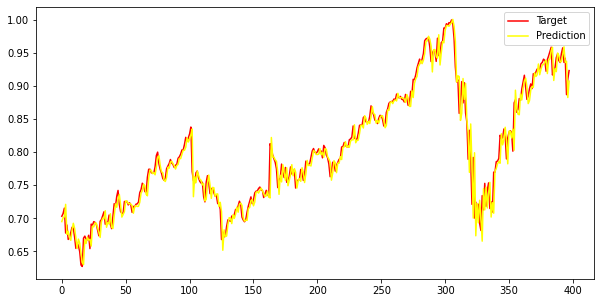

In [ ]:
# ploting the graph
comp = pd.DataFrame({'Column1':y_test[:,3],'Column2':y_test_pred[:,3]})
plt.figure(figsize=(10,5))
plt.plot(comp['Column1'], color='red', label='Target')
plt.plot(comp['Column2'], color='yellow', label='Prediction')
plt.legend()
plt.show()